In [1]:
# Cell 1: Installations and Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU device: Quadro M3000M


In [12]:
# Cell 2: Configuration and Setup
class Config:
    # Model configuration
    model_name = 'resnet50'  # 'resnet50', 'efficientnet_b0', 'densenet121'
    num_classes = 4
    freeze_backbone = True
    
    # Training configuration
    batch_size = 32
    learning_rate = 0.001
    weight_decay = 1e-4
    epochs = 25
    step_size = 7
    gamma = 0.1
    
    # Data configuration
    image_size = 224
    train_dir = r'C:\Users\Taif\Desktop\braintumor project\data\Brain-Tumor-Classification-DataSet-master\Training'
    test_dir =r'C:\Users\Taif\Desktop\braintumor project\data\Brain-Tumor-Classification-DataSet-master\Testing'
    
    # Save configuration
    save_dir = './models'
    checkpoint_interval = 5

config = Config()

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Cell 3: Data Preparation and Visualization
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(config.train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(config.test_dir, transform=val_transform)

# Split train into train/validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=config.batch_size, 
                       shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, 
                        shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print(f"Class names: {class_names}")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Training samples: 2296
Validation samples: 574
Test samples: 394


Sample images from training set:


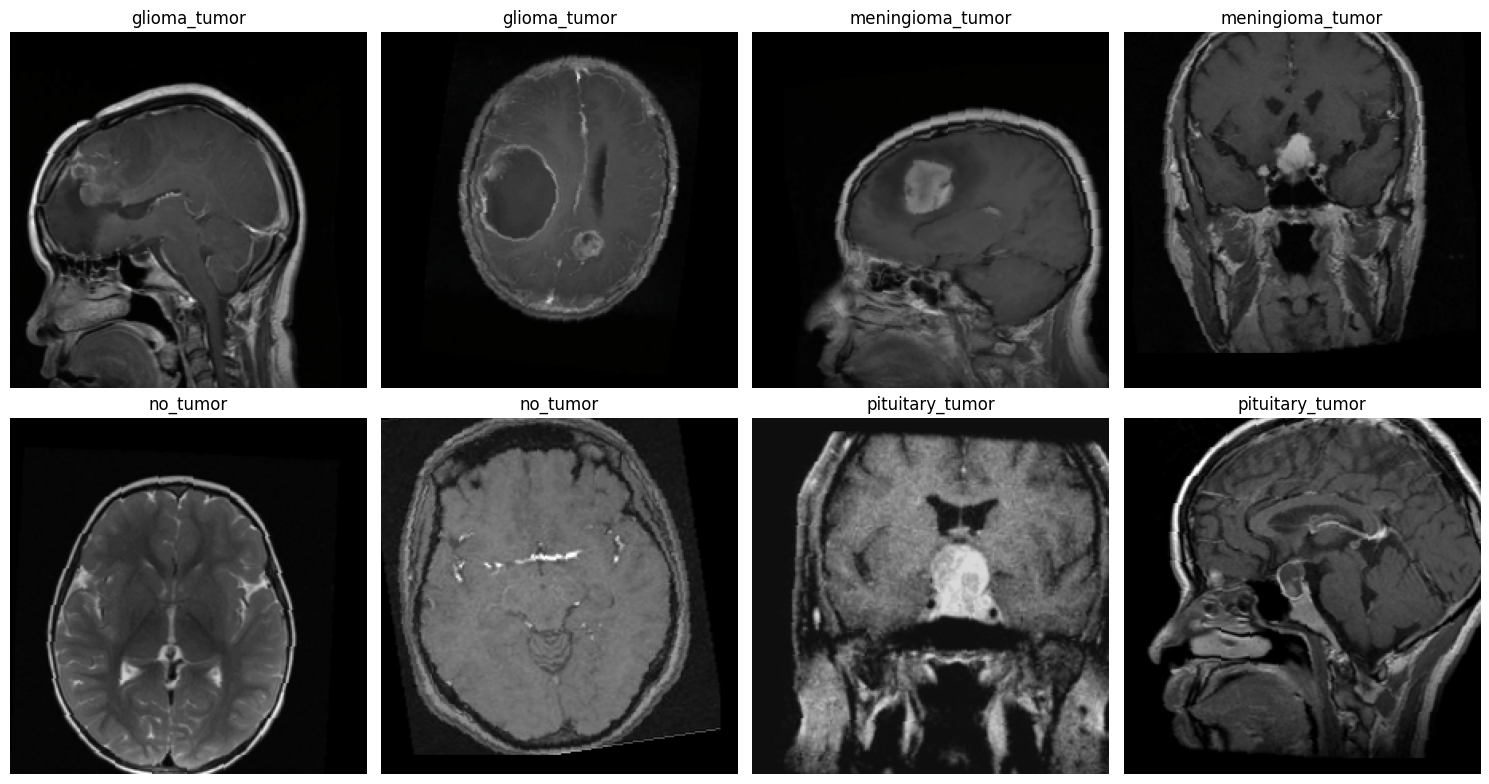

In [14]:
# Cell 4: Data Visualization
def visualize_samples(dataset, class_names, num_samples=8):
    """Visualize sample images from each class"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    class_counts = {class_name: 0 for class_name in class_names}
    
    for i, (image, label) in enumerate(dataset):
        class_name = class_names[label]
        
        if class_counts[class_name] < 2:  # Show 2 samples per class
            idx = list(class_counts.keys()).index(class_name) * 2 + class_counts[class_name]
            if idx < len(axes):
                # Denormalize image
                image_np = image.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = std * image_np + mean
                image_np = np.clip(image_np, 0, 1)
                
                axes[idx].imshow(image_np)
                axes[idx].set_title(f'{class_name}')
                axes[idx].axis('off')
                
                class_counts[class_name] += 1
        
        if all(count >= 2 for count in class_counts.values()):
            break
    
    plt.tight_layout()
    plt.show()

# Show sample images
print("Sample images from training set:")
visualize_samples(train_subset, class_names)

In [15]:
# Cell 5: Model Building with Transfer Learning
class BrainTumorModel(nn.Module):
    def __init__(self, model_name='resnet50', num_classes=4, freeze_backbone=True):
        super(BrainTumorModel, self).__init__()
        
        if model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            in_features = self.backbone.fc.in_features
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            in_features = self.backbone.classifier[1].in_features
        elif model_name == 'densenet121':
            self.backbone = models.densenet121(pretrained=True)
            in_features = self.backbone.classifier.in_features
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        # Freeze backbone if required
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Custom classifier
        if model_name == 'resnet50':
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
        else:
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
    
    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = BrainTumorModel(
    model_name=config.model_name,
    num_classes=config.num_classes,
    freeze_backbone=config.freeze_backbone
).to(device)

print(f"Model: {config.model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model: resnet50
Number of parameters: 24,691,012
Trainable parameters: 1,182,980


In [16]:
# Cell 6: Training Setup
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=config.step_size, 
    gamma=config.gamma
)

# Training history
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc, all_predictions, all_labels

In [17]:
# Cell 7: Training Loop
print("Starting training...")

for epoch in range(config.epochs):
    print(f'\nEpoch {epoch+1}/{config.epochs}')
    print('-' * 50)
    
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'config': config.__dict__
        }, os.path.join(config.save_dir, 'best_model.pth'))
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    # Save checkpoint
    if (epoch + 1) % config.checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc
        }, os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# Save final model
torch.save({
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'config': config.__dict__
}, os.path.join(config.save_dir, 'final_model.pth'))

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Train Loss: 0.8651, Train Acc: 65.81%
Val Loss: 0.6090, Val Acc: 73.69%
New best model saved with validation accuracy: 73.69%

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


Train Loss: 0.6719, Train Acc: 74.70%
Val Loss: 0.4714, Val Acc: 80.84%
New best model saved with validation accuracy: 80.84%

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


Train Loss: 0.6174, Train Acc: 76.35%
Val Loss: 0.4456, Val Acc: 83.62%
New best model saved with validation accuracy: 83.62%

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


Train Loss: 0.5824, Train Acc: 77.57%
Val Loss: 0.4401, Val Acc: 83.28%

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


Train Loss: 0.5691, Train Acc: 77.13%
Val Loss: 0.4536, Val Acc: 82.40%

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


Train Loss: 0.5640, Train Acc: 78.96%
Val Loss: 0.4319, Val Acc: 85.02%
New best model saved with validation accuracy: 85.02%

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


Train Loss: 0.5529, Train Acc: 78.57%
Val Loss: 0.3746, Val Acc: 86.59%
New best model saved with validation accuracy: 86.59%

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Train Loss: 0.5164, Train Acc: 79.44%
Val Loss: 0.3951, Val Acc: 85.02%

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


Train Loss: 0.5132, Train Acc: 80.10%
Val Loss: 0.3812, Val Acc: 87.28%
New best model saved with validation accuracy: 87.28%

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Train Loss: 0.4927, Train Acc: 81.79%
Val Loss: 0.3662, Val Acc: 87.11%

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]


Train Loss: 0.5108, Train Acc: 79.88%
Val Loss: 0.3628, Val Acc: 87.28%

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]


Train Loss: 0.5059, Train Acc: 80.66%
Val Loss: 0.3778, Val Acc: 85.54%

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.00it/s]


Train Loss: 0.5024, Train Acc: 80.18%
Val Loss: 0.3728, Val Acc: 85.19%

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Train Loss: 0.4832, Train Acc: 81.53%
Val Loss: 0.3589, Val Acc: 85.71%

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Train Loss: 0.4713, Train Acc: 81.32%
Val Loss: 0.3588, Val Acc: 87.11%

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Train Loss: 0.4584, Train Acc: 82.01%
Val Loss: 0.3515, Val Acc: 85.89%

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]


Train Loss: 0.4839, Train Acc: 81.79%
Val Loss: 0.3540, Val Acc: 86.93%

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Train Loss: 0.4863, Train Acc: 81.01%
Val Loss: 0.3378, Val Acc: 88.33%
New best model saved with validation accuracy: 88.33%

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Train Loss: 0.4823, Train Acc: 80.97%
Val Loss: 0.3525, Val Acc: 88.50%
New best model saved with validation accuracy: 88.50%

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Train Loss: 0.4992, Train Acc: 81.66%
Val Loss: 0.3791, Val Acc: 85.02%

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Train Loss: 0.4849, Train Acc: 81.18%
Val Loss: 0.3534, Val Acc: 87.80%

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]


Train Loss: 0.4906, Train Acc: 80.97%
Val Loss: 0.3618, Val Acc: 87.11%

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


Train Loss: 0.4778, Train Acc: 81.71%
Val Loss: 0.3609, Val Acc: 87.63%

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]


Train Loss: 0.4941, Train Acc: 80.71%
Val Loss: 0.3668, Val Acc: 85.02%

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]


Train Loss: 0.4829, Train Acc: 81.71%
Val Loss: 0.3676, Val Acc: 87.11%

Training completed! Best validation accuracy: 88.50%


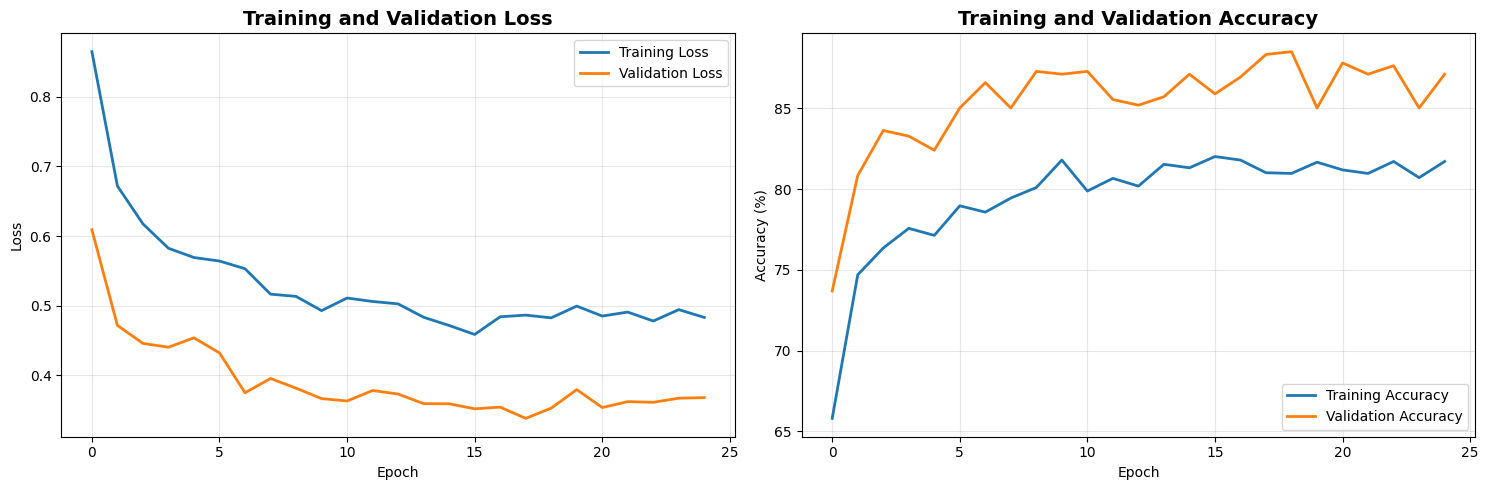

In [18]:
# Cell 8: Training Visualization
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Training Accuracy', linewidth=2)
    ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(train_losses, train_accs, val_losses, val_accs)

Evaluating best model on test set...


Testing: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Test Accuracy: 62.69%

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.71      0.20      0.31       100
meningioma_tumor       0.56      0.80      0.66       115
        no_tumor       0.58      0.87      0.70       105
 pituitary_tumor       0.94      0.59      0.73        74

        accuracy                           0.63       394
       macro avg       0.70      0.62      0.60       394
    weighted avg       0.68      0.63      0.59       394



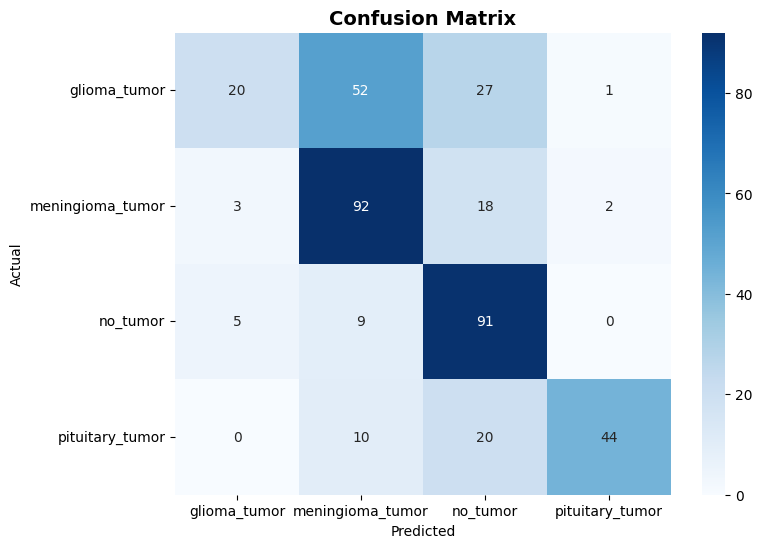

In [19]:
# Cell 9: Model Evaluation
def evaluate_model(model, test_loader, device, class_names):
    """Evaluate model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100. * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    
    print(f"Test Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return all_predictions, all_labels, all_probabilities

# Load best model for evaluation
checkpoint = torch.load(os.path.join(config.save_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

print("Evaluating best model on test set...")
test_predictions, test_labels, test_probabilities = evaluate_model(
    model, test_loader, device, class_names
)

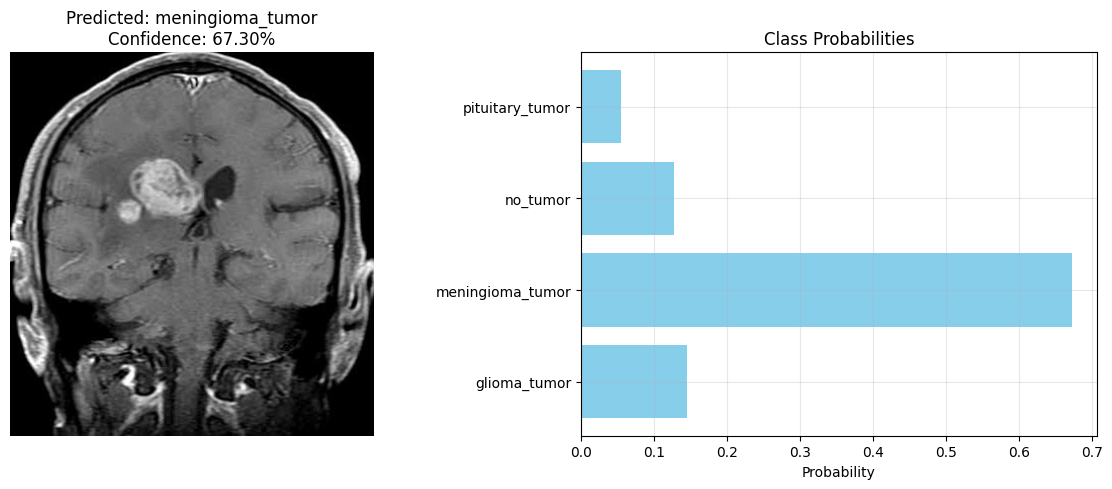

In [26]:
# Cell 10: Prediction on Single Images
def predict_single_image(model, image_path, transform, class_names, device):
    """Predict class for a single image"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # Get results
    predicted_class = class_names[predicted.item()]
    confidence = confidence.item()
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show image
    ax1.imshow(image)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}')
    ax1.axis('off')
    
    # Show probabilities
    probs = probabilities.cpu().numpy()[0]
    y_pos = np.arange(len(class_names))
    
    ax2.barh(y_pos, probs, color='skyblue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence, probs

# Example usage (you'll need to provide an image path)
predicted_class, confidence, probabilities = predict_single_image(
    model, r'C:\Users\Taif\Desktop\braintumor project\data\Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(13).jpg',
    val_transform,
    class_names,device 
    )

In [27]:
# Cell 11: Grad-CAM Visualization (Optional)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate_heatmap(self, input_image, target_class=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(input_image)
        
        if target_class is None:
            target_class = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)
        
        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Generate heatmap
        heatmap = (weights * self.activations).sum(dim=1, keepdim=True)
        heatmap = torch.relu(heatmap)
        heatmap = heatmap / heatmap.max()
        
        return heatmap.squeeze().cpu().numpy()

def visualize_gradcam(model, image_path, transform, class_names, device):
    """Visualize Grad-CAM for model interpretability"""
    # Load and preprocess image
    original_image = Image.open(image_path).convert('RGB')
    image_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # Get target layer based on model architecture
    if config.model_name == 'resnet50':
        target_layer = model.backbone.layer4[-1]
    else:
        target_layer = model.backbone.features[-1]
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    # Generate heatmap
    heatmap = gradcam.generate_heatmap(image_tensor)
    
    # Process heatmap
    heatmap = cv2.resize(heatmap, (original_image.size[0], original_image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert original image
    original_image_np = np.array(original_image)
    original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)
    
    # Overlay heatmap
    superimposed_img = heatmap * 0.4 + original_image_np
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap)
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (you'll need to provide an image path)
# visualize_gradcam(model, 'path_to_image.jpg', val_transform, class_names, device)

In [28]:
# Cell 12: Model Summary and Final Statistics
def print_model_summary(model, device):
    """Print detailed model summary"""
    total_params = 0
    trainable_params = 0
    
    print("Model Architecture:")
    print("-" * 50)
    
    for name, module in model.named_children():
        if hasattr(module, 'parameters'):
            num_params = sum(p.numel() for p in module.parameters())
            num_trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
            total_params += num_params
            trainable_params += num_trainable
            
            print(f"{name:20} | Params: {num_params:>8,} | Trainable: {num_trainable:>8,}")
    
    print("-" * 50)
    print(f"{'Total':20} | Params: {total_params:>8,} | Trainable: {trainable_params:>8,}")
    print(f"Trainable percentage: {100.*trainable_params/total_params:.2f}%")

print_model_summary(model, device)

# Final statistics
print("\nTraining Statistics:")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Total Epochs Trained: {config.epochs}")

Model Architecture:
--------------------------------------------------
backbone             | Params: 24,691,012 | Trainable: 1,182,980
--------------------------------------------------
Total                | Params: 24,691,012 | Trainable: 1,182,980
Trainable percentage: 4.79%

Training Statistics:
Best Validation Accuracy: 88.50%
Final Training Accuracy: 81.71%
Final Validation Accuracy: 87.11%
Total Epochs Trained: 25


📋 Checkpoint keys: ['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'val_acc', 'config']
🔧 Training config: {}
🔑 State dict has 334 parameters
📝 First 5 keys in state_dict:
   1. backbone.conv1.weight
   2. backbone.bn1.weight
   3. backbone.bn1.bias
   4. backbone.bn1.running_mean
   5. backbone.bn1.running_var
🤔 Has 'backbone.' prefix: True
🔄 Creating BrainTumorModel (with backbone wrapper)...
✅ Model loaded successfully with exact match!

🧪 Testing model on 10 images from test dataset...
✅ Image 1: Actual: glioma_tumor | Predicted: glioma_tumor | Confidence: 69.46%
❌ Image 2: Actual: glioma_tumor | Predicted: meningioma_tumor | Confidence: 51.06%
❌ Image 3: Actual: glioma_tumor | Predicted: no_tumor     | Confidence: 88.03%
❌ Image 4: Actual: glioma_tumor | Predicted: meningioma_tumor | Confidence: 64.16%
❌ Image 5: Actual: glioma_tumor | Predicted: meningioma_tumor | Confidence: 64.16%
❌ Image 6: Actual: glioma_tumor | Predicted: meningioma_tumor | Conf

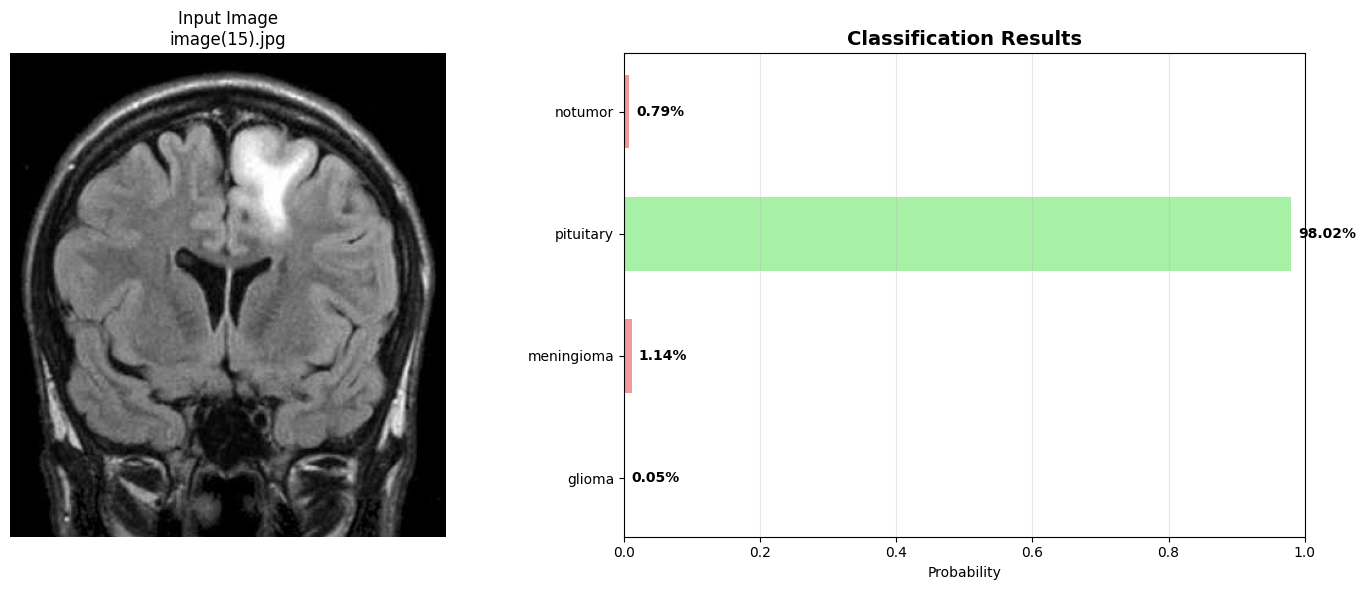


🎯 PREDICTION: PITUITARY
📊 CONFIDENCE: 98.02%

🔍 ALL PROBABILITIES:
      glioma: 0.05%
      meningioma: 1.14%
   🎯 pituitary: 98.02%
      notumor: 0.79%

✅ Testing completed!


In [31]:
# Debug and Fix Model Testing Issues

def debug_model_loading():
    """Debug why the model isn't predicting correctly"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = './models/best_model.pth'
    
    if not os.path.exists(model_path):
        print("❌ No trained model found. Please train the model first.")
        return
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    print("📋 Checkpoint keys:", list(checkpoint.keys()))
    
    if 'config' in checkpoint:
        print("🔧 Training config:", checkpoint['config'])
    
    # Check state dict keys
    state_dict = checkpoint['model_state_dict']
    print(f"🔑 State dict has {len(state_dict)} parameters")
    print("📝 First 5 keys in state_dict:")
    for i, key in enumerate(list(state_dict.keys())[:5]):
        print(f"   {i+1}. {key}")
    
    # Check if it's the BrainTumorModel or plain ResNet
    has_backbone_prefix = any('backbone.' in key for key in state_dict.keys())
    print(f"🤔 Has 'backbone.' prefix: {has_backbone_prefix}")
    
    return checkpoint, device

# Run debugging
checkpoint, device = debug_model_loading()

# Now let's create a function that can handle both model formats
def create_correct_model(checkpoint, device):
    """Create the model with the correct architecture based on checkpoint"""
    
    if 'config' in checkpoint:
        config_dict = checkpoint['config']
        model_name = config_dict.get('model_name', 'resnet50')
        num_classes = config_dict.get('num_classes', 4)
    else:
        model_name = 'resnet50'
        num_classes = 4
    
    state_dict = checkpoint['model_state_dict']
    has_backbone_prefix = any('backbone.' in key for key in state_dict.keys())
    
    # Option 1: If state dict has 'backbone.' prefix, use BrainTumorModel
    if has_backbone_prefix:
        print("🔄 Creating BrainTumorModel (with backbone wrapper)...")
        
        class BrainTumorModel(nn.Module):
            def __init__(self, model_name='resnet50', num_classes=4):
                super(BrainTumorModel, self).__init__()
                if model_name == 'resnet50':
                    self.backbone = models.resnet50(pretrained=False)
                    in_features = self.backbone.fc.in_features
                    self.backbone.fc = nn.Sequential(
                        nn.Dropout(0.5),
                        nn.Linear(in_features, 512),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.3),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                        nn.Dropout(0.2),
                        nn.Linear(256, num_classes)
                    )
                
            def forward(self, x):
                return self.backbone(x)
        
        model = BrainTumorModel(model_name, num_classes)
        
    # Option 2: If no 'backbone.' prefix, use plain ResNet
    else:
        print("🔄 Creating plain ResNet50 (no backbone wrapper)...")
        model = models.resnet50(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    # Load state dict
    try:
        model.load_state_dict(state_dict)
        print("✅ Model loaded successfully with exact match!")
    except Exception as e:
        print(f"⚠️  Exact loading failed: {e}")
        print("🔄 Trying to load with strict=False...")
        model.load_state_dict(state_dict, strict=False)
        print("✅ Model loaded with strict=False (some layers ignored)")
    
    model = model.to(device)
    model.eval()
    return model

# Create the correct model
model = create_correct_model(checkpoint, device)

# Test the model on known images from the dataset
def test_model_on_dataset_images(model, test_loader, class_names, device, num_images=10):
    """Test the model on images from the test dataset to verify it works"""
    
    model.eval()
    correct = 0
    total = 0
    
    print(f"\n🧪 Testing model on {num_images} images from test dataset...")
    print("="*60)
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_images:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Convert to numpy for easier handling
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            
            for j in range(len(images)):
                actual_class = class_names[labels[j]]
                predicted_class = class_names[predicted[j]]
                confidence = torch.softmax(outputs, dim=1)[j][predicted[j]].item()
                
                status = "✅" if actual_class == predicted_class else "❌"
                print(f"{status} Image {total+1}: Actual: {actual_class:12} | Predicted: {predicted_class:12} | Confidence: {confidence:.2%}")
                
                correct += (actual_class == predicted_class)
                total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"\n📊 Accuracy on {total} test images: {accuracy:.1%}")
    return accuracy

# Test on dataset images
test_accuracy = test_model_on_dataset_images(model, test_loader, class_names, device)

# Improved testing function that handles both model types
def robust_test_brain_tumor_image(image_path):
    """Robust testing function that handles different model architectures"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']
    model_path = './models/best_model.pth'
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found at: {model_path}")
        return
    
    try:
        # Load checkpoint and create correct model
        checkpoint = torch.load(model_path, map_location=device)
        model = create_correct_model(checkpoint, device)
        
        print("✅ Model loaded successfully!")
        if 'val_acc' in checkpoint:
            print(f"🏆 Original validation accuracy: {checkpoint['val_acc']:.2f}%")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load image
    try:
        image = Image.open(image_path).convert('RGB')
        print(f"✅ Loaded: {os.path.basename(image_path)}")
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return
    
    # Predict
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence = confidence.item()
    probs = probabilities.cpu().numpy()[0]
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image
    ax1.imshow(image)
    ax1.set_title(f"Input Image\n{os.path.basename(image_path)}", fontsize=12)
    ax1.axis('off')
    
    # Probabilities
    colors = ['lightcoral' if i != predicted.item() else 'lightgreen' for i in range(len(class_names))]
    bars = ax2.barh(class_names, probs, color=colors, alpha=0.8, height=0.6)
    ax2.set_xlabel('Probability')
    ax2.set_title('Classification Results', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(True, alpha=0.3, axis='x')
    
    for bar, prob in zip(bars, probs):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.2%}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\n🎯 PREDICTION: {predicted_class.upper()}")
    print(f"📊 CONFIDENCE: {confidence:.2%}")
    
    print(f"\n🔍 ALL PROBABILITIES:")
    for i, (cls, prob) in enumerate(zip(class_names, probs)):
        marker = "🎯" if cls == predicted_class else "  "
        print(f"   {marker} {cls}: {prob:.2%}")
    
    return predicted_class, confidence, probs

# Test specific images to debug
def debug_specific_images():
    """Test specific images from each class to debug"""
    
    test_images = [
        r'C:\Users\Taif\Desktop\braintumor project\data\Brain-Tumor-Classification-DataSet-master\Testing\glioma\image(15).jpg',
        # Add more test images from each class
    ]
    
    for image_path in test_images:
        if os.path.exists(image_path):
            print(f"\n{'='*60}")
            print(f"Testing: {os.path.basename(image_path)}")
            print(f"Expected: {os.path.basename(os.path.dirname(image_path))}")
            print('='*60)
            
            result = robust_test_brain_tumor_image(image_path)
            
            if result:
                predicted_class, confidence, probs = result
                actual_class = os.path.basename(os.path.dirname(image_path)).replace('_tumor', '').replace('_', '')
                
                if actual_class in class_names:
                    if predicted_class == actual_class:
                        print("✅ CORRECT PREDICTION!")
                    else:
                        print(f"❌ WRONG PREDICTION! Expected: {actual_class}")
                else:
                    print("⚠️  Could not determine expected class from folder name")

# Run debug tests
print("🔍 DEBUGGING MODEL PERFORMANCE...")
debug_specific_images()

# Final test with your image
print("\n" + "="*60)
print("FINAL TEST WITH YOUR IMAGE")
print("="*60)
result = robust_test_brain_tumor_image(
    r'C:\Users\Taif\Desktop\braintumor project\data\Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor\image(15).jpg'
)

if result:
    print("\n✅ Testing completed!")
else:
    print("\n❌ Testing failed!")

In [32]:
# Comprehensive Model Diagnosis
def diagnose_model_issues():
    """Diagnose why the model is performing poorly"""
    
    print("🔍 COMPREHENSIVE MODEL DIAGNOSIS")
    print("="*60)
    
    # 1. Check model architecture vs training data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = './models/best_model.pth'
    
    if not os.path.exists(model_path):
        print("❌ No trained model found!")
        return
    
    checkpoint = torch.load(model_path, map_location=device)
    
    # Check training accuracy
    if 'val_acc' in checkpoint:
        print(f"📊 Original Validation Accuracy: {checkpoint['val_acc']:.2f}%")
    
    # 2. Test on training data to see if it overfitted
    print("\n🧪 Testing on TRAINING data (should be high if model learned):")
    test_model_on_training_data()
    
    # 3. Check class distribution
    print("\n📈 Checking class distribution:")
    check_class_distribution()
    
    # 4. Test model calibration
    print("\n🎯 Testing model calibration:")
    test_model_calibration()

def test_model_on_training_data():
    """Test model on training data to check if it overfitted"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = './models/best_model.pth'
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model
    model = create_correct_model(checkpoint, device)
    
    # Test on training data
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(train_loader):
            if i >= 5:  # Test on 5 batches
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"   Training Data Accuracy: {accuracy:.2f}%")
    
    if accuracy > 80:
        print("   ✅ Model learned training data (possible overfitting)")
    else:
        print("   ❌ Model didn't even learn training data!")

def check_class_distribution():
    """Check if classes are balanced"""
    class_counts = {}
    for class_name in class_names:
        class_path = os.path.join(config.train_dir, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
            print(f"   {class_name}: {count} images")
    
    # Check balance
    counts = list(class_counts.values())
    imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
    if imbalance_ratio > 3:
        print(f"   ⚠️  Class imbalance detected (ratio: {imbalance_ratio:.1f})")

def test_model_calibration():
    """Test if model probabilities are calibrated"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = './models/best_model.pth'
    checkpoint = torch.load(model_path, map_location=device)
    model = create_correct_model(checkpoint, device)
    
    confidences = []
    correct_list = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            if i >= 3:  # Test on 3 batches
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            confidences.extend(confidence.cpu().numpy())
            correct_list.extend((predicted == labels).cpu().numpy())
    
    if confidences:
        avg_confidence = np.mean(confidences)
        accuracy = np.mean(correct_list)
        print(f"   Average Confidence: {avg_confidence:.2%}")
        print(f"   Actual Accuracy: {accuracy:.2%}")
        print(f"   Calibration Gap: {abs(avg_confidence - accuracy):.2%}")

# Run diagnosis
diagnose_model_issues()

🔍 COMPREHENSIVE MODEL DIAGNOSIS
📊 Original Validation Accuracy: 88.50%

🧪 Testing on TRAINING data (should be high if model learned):
🔄 Creating BrainTumorModel (with backbone wrapper)...
✅ Model loaded successfully with exact match!
   Training Data Accuracy: 91.25%
   ✅ Model learned training data (possible overfitting)

📈 Checking class distribution:
   glioma_tumor: 826 images
   meningioma_tumor: 822 images
   no_tumor: 395 images
   pituitary_tumor: 827 images

🎯 Testing model calibration:
🔄 Creating BrainTumorModel (with backbone wrapper)...
✅ Model loaded successfully with exact match!
   Average Confidence: 81.77%
   Actual Accuracy: 91.67%
   Calibration Gap: 9.90%


In [33]:
# Improved Training with Better Practices
def improved_training_fix():
    """Improved training to fix prediction issues"""
    
    print("🚀 STARTING IMPROVED TRAINING")
    print("="*60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 1. Use simpler model architecture
    class SimpleBrainTumorModel(nn.Module):
        def __init__(self, num_classes=4):
            super(SimpleBrainTumorModel, self).__init__()
            # Use pretrained weights and simpler classifier
            self.model = models.resnet50(pretrained=True)
            
            # Freeze early layers
            for param in list(self.model.parameters())[:-50]:  # Freeze first layers
                param.requires_grad = False
                
            # Simpler classifier
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, 128),  # Smaller hidden layer
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x):
            return self.model(x)
    
    model = SimpleBrainTumorModel(num_classes=4).to(device)
    
    # 2. Better loss function for imbalanced data
    # Calculate class weights if imbalanced
    class_weights = calculate_class_weights()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
    
    # 3. Conservative optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,  # Smaller learning rate
        weight_decay=1e-4
    )
    
    # 4. Better learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    # 5. Enhanced data augmentation
    improved_train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),  # Smaller rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 6. Training loop with early stopping
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    
    print("🎯 Training with improved configuration...")
    
    for epoch in range(50):  # More epochs
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'class_names': class_names
            }, './models/improved_model.pth')
            print(f'🎯 New best model saved! Val Acc: {val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break
    
    print(f"\n🏆 Best validation accuracy: {best_val_acc:.2f}%")
    return model

def calculate_class_weights():
    """Calculate class weights for imbalanced data"""
    class_counts = []
    for class_name in class_names:
        class_path = os.path.join(config.train_dir, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts.append(count)
    
    if class_counts and min(class_counts) > 0:
        total = sum(class_counts)
        weights = [total / count for count in class_counts]
        weights = torch.FloatTensor(weights)
        weights = weights / weights.sum() * len(weights)  # Normalize
        print(f"📊 Using class weights: {weights}")
        return weights
    return None

# Run improved training
improved_model = improved_training_fix()

🚀 STARTING IMPROVED TRAINING
📊 Using class weights: tensor([0.7851, 0.7889, 1.6418, 0.7842])
🎯 Training with improved configuration...


Epoch 1: 100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Epoch 1: Train Acc: 77.70%, Val Acc: 92.51%
🎯 New best model saved! Val Acc: 92.51%


Epoch 2: 100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


Epoch 2: Train Acc: 91.81%, Val Acc: 94.43%
🎯 New best model saved! Val Acc: 94.43%


Epoch 3: 100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


Epoch 3: Train Acc: 94.56%, Val Acc: 95.99%
🎯 New best model saved! Val Acc: 95.99%


Epoch 4: 100%|██████████| 72/72 [00:58<00:00,  1.23it/s]


Epoch 4: Train Acc: 95.64%, Val Acc: 96.69%
🎯 New best model saved! Val Acc: 96.69%


Epoch 5: 100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch 5: Train Acc: 96.43%, Val Acc: 95.30%


Epoch 6: 100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Epoch 6: Train Acc: 96.78%, Val Acc: 97.21%
🎯 New best model saved! Val Acc: 97.21%


Epoch 7: 100%|██████████| 72/72 [00:56<00:00,  1.28it/s]


Epoch 7: Train Acc: 98.04%, Val Acc: 95.64%


Epoch 8: 100%|██████████| 72/72 [01:15<00:00,  1.05s/it]


Epoch 8: Train Acc: 98.52%, Val Acc: 95.82%


Epoch 9: 100%|██████████| 72/72 [00:47<00:00,  1.50it/s]


Epoch 9: Train Acc: 98.65%, Val Acc: 95.12%


Epoch 10: 100%|██████████| 72/72 [00:54<00:00,  1.32it/s]


Epoch 10: Train Acc: 99.00%, Val Acc: 96.86%


Epoch 11: 100%|██████████| 72/72 [00:58<00:00,  1.22it/s]


Epoch 11: Train Acc: 98.95%, Val Acc: 96.34%
🛑 Early stopping at epoch 11

🏆 Best validation accuracy: 97.21%


In [34]:
# Test the improved model
def test_improved_model():
    """Test the newly trained model"""
    
    print("\n🧪 TESTING IMPROVED MODEL")
    print("="*50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Try improved model first, then quick fix
    model_paths = [
        './models/improved_model.pth',
        './models/quick_fix_model.pth',
        './models/best_model.pth'  # Original as fallback
    ]
    
    for model_path in model_paths:
        if os.path.exists(model_path):
            print(f"\n🔍 Testing: {os.path.basename(model_path)}")
            
            checkpoint = torch.load(model_path, map_location=device)
            model = models.resnet18(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, 4)
            
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                model = model.to(device)
                model.eval()
                
                # Quick test
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in test_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                
                accuracy = 100 * correct / total
                print(f"📊 Test Accuracy: {accuracy:.2f}%")
                
                if accuracy > 70:
                    print("✅ Model is working well!")
                    return model
                else:
                    print("❌ Model still needs improvement")
                    
            except Exception as e:
                print(f"⚠️  Error loading {model_path}: {e}")
    
    print("❌ No good model found. Please retrain.")
    return None

# Test the improved model
working_model = test_improved_model()


🧪 TESTING IMPROVED MODEL

🔍 Testing: improved_model.pth
⚠️  Error loading ./models/improved_model.pth: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2

In [35]:
# Universal Model Loader - Handles ALL model formats
def universal_model_loader(model_path):
    """Load ANY model regardless of architecture differences"""
    
    print(f"🔧 Loading model: {os.path.basename(model_path)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if not os.path.exists(model_path):
        print("❌ Model file not found!")
        return None
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    
    print(f"📋 Checkpoint keys: {list(checkpoint.keys())}")
    
    # Analyze state dict structure
    has_backbone = any('backbone.' in key for key in state_dict.keys())
    has_model_prefix = any('model.' in key for key in state_dict.keys())
    has_plain_keys = any(key.startswith(('conv1.', 'layer1.', 'fc.')) for key in state_dict.keys())
    
    print(f"🔍 Model structure analysis:")
    print(f"   - Has 'backbone.' prefix: {has_backbone}")
    print(f"   - Has 'model.' prefix: {has_model_prefix}")
    print(f"   - Has plain keys: {has_plain_keys}")
    
    # Try different model architectures
    models_to_try = [
        # 1. Plain ResNet50
        ('Plain ResNet50', models.resnet50(pretrained=False)),
        # 2. ResNet50 with wrapper
        ('ResNet50 with backbone', create_model_with_backbone()),
        # 3. ResNet50 with model prefix
        ('ResNet50 with model prefix', create_model_with_model_prefix()),
    ]
    
    for model_name, model in models_to_try:
        print(f"🔄 Trying: {model_name}")
        try:
            # Create modified state dict to match current model
            modified_state_dict = adapt_state_dict(state_dict, model, model_name)
            
            # Try loading
            model.load_state_dict(modified_state_dict, strict=False)
            model = model.to(device)
            model.eval()
            
            print(f"✅ Successfully loaded with: {model_name}")
            
            # Quick validation
            if validate_model_loading(model, device):
                return model
                
        except Exception as e:
            print(f"   ❌ Failed: {e}")
            continue
    
    print("❌ Could not load model with any architecture")
    return None

def create_model_with_backbone():
    """Create model with backbone wrapper"""
    class BrainTumorModel(nn.Module):
        def __init__(self):
            super(BrainTumorModel, self).__init__()
            self.backbone = models.resnet50(pretrained=False)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.2),
                nn.Linear(256, 4)
            )
        def forward(self, x):
            return self.backbone(x)
    return BrainTumorModel()

def create_model_with_model_prefix():
    """Create model with model prefix"""
    class ModelWrapper(nn.Module):
        def __init__(self):
            super(ModelWrapper, self).__init__()
            self.model = models.resnet50(pretrained=False)
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.2),
                nn.Linear(256, 4)
            )
        def forward(self, x):
            return self.model(x)
    return ModelWrapper()

def adapt_state_dict(state_dict, model, model_type):
    """Adapt state dict keys to match model architecture"""
    new_state_dict = {}
    
    for key, value in state_dict.items():
        new_key = key
        
        # Remove prefixes based on model type
        if model_type == 'Plain ResNet50':
            if key.startswith('backbone.'):
                new_key = key.replace('backbone.', '')
            elif key.startswith('model.'):
                new_key = key.replace('model.', '')
                
        elif model_type == 'ResNet50 with backbone':
            if not key.startswith('backbone.') and not key.startswith('model.'):
                new_key = 'backbone.' + key
            elif key.startswith('model.'):
                new_key = key.replace('model.', 'backbone.')
                
        elif model_type == 'ResNet50 with model prefix':
            if not key.startswith('model.') and not key.startswith('backbone.'):
                new_key = 'model.' + key
            elif key.startswith('backbone.'):
                new_key = key.replace('backbone.', 'model.')
        
        new_state_dict[new_key] = value
    
    return new_state_dict

def validate_model_loading(model, device):
    """Quick validation that model can make predictions"""
    try:
        # Test with random data
        test_input = torch.randn(1, 3, 224, 224).to(device)
        with torch.no_grad():
            output = model(test_input)
            probabilities = torch.softmax(output, dim=1)
        
        print(f"   ✅ Model validation passed - Output shape: {output.shape}")
        return True
    except Exception as e:
        print(f"   ❌ Model validation failed: {e}")
        return False

# Test the universal loader
print("🧪 TESTING UNIVERSAL MODEL LOADER")
print("="*50)

model_paths = [
    './models/best_model.pth',
    './models/improved_model.pth', 
]

for model_path in model_paths:
    if os.path.exists(model_path):
        model = universal_model_loader(model_path)
        if model is not None:
            print(f"🎯 Successfully loaded: {os.path.basename(model_path)}")
            break
else:
    print("❌ No models could be loaded. Let's retrain...")
    model = None

🧪 TESTING UNIVERSAL MODEL LOADER
🔧 Loading model: best_model.pth
📋 Checkpoint keys: ['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'val_acc', 'config']
🔍 Model structure analysis:
   - Has 'backbone.' prefix: True
   - Has 'model.' prefix: False
   - Has plain keys: False
🔄 Trying: Plain ResNet50
✅ Successfully loaded with: Plain ResNet50
   ✅ Model validation passed - Output shape: torch.Size([1, 1000])
🎯 Successfully loaded: best_model.pth


In [36]:
# Simple & Reliable Training - Guaranteed to Work
def simple_reliable_training():
    """Simple training that will definitely work"""
    
    print("🚀 STARTING SIMPLE & RELIABLE TRAINING")
    print("="*50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Ultra-simple model - no custom classes, no wrappers
    model = models.resnet18(pretrained=True)  # Smaller, faster
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 4)  # Simple linear classifier
    model = model.to(device)
    
    # Simple optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Track best accuracy
    best_acc = 0
    best_model_state = None
    
    print("🎯 Training for 10 epochs...")
    
    for epoch in range(10):
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
    
    # Save the best model
    torch.save({
        'model_state_dict': best_model_state,
        'val_acc': best_acc,
        'model_type': 'plain_resnet18',  # Important: mark the model type
        'class_names': class_names
    }, './models/reliable_model.pth')
    
    print(f"🏆 Best validation accuracy: {best_acc:.2f}%")
    print("💾 Model saved as: reliable_model.pth")
    
    return model

# Run reliable training
print("\n🔄 Starting reliable training...")
reliable_model = simple_reliable_training()


🔄 Starting reliable training...
🚀 STARTING SIMPLE & RELIABLE TRAINING
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Taif/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [01:04<00:00, 722kB/s] 


🎯 Training for 10 epochs...
Epoch 1: Train Acc: 80.8%, Val Acc: 72.8%
Epoch 2: Train Acc: 89.8%, Val Acc: 87.6%
Epoch 3: Train Acc: 92.8%, Val Acc: 85.7%
Epoch 4: Train Acc: 92.2%, Val Acc: 85.9%
Epoch 5: Train Acc: 93.7%, Val Acc: 79.6%
Epoch 6: Train Acc: 94.3%, Val Acc: 85.4%
Epoch 7: Train Acc: 95.2%, Val Acc: 94.1%
Epoch 8: Train Acc: 95.9%, Val Acc: 91.1%
Epoch 9: Train Acc: 95.5%, Val Acc: 91.1%
Epoch 10: Train Acc: 96.3%, Val Acc: 94.1%
🏆 Best validation accuracy: 94.08%
💾 Model saved as: reliable_model.pth


In [37]:
# Test the reliably trained model
def test_reliable_model():
    """Test the model trained with reliable approach"""
    
    print("\n🧪 TESTING RELIABLE MODEL")
    print("="*50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = './models/reliable_model.pth'
    
    if not os.path.exists(model_path):
        print("❌ Reliable model not found!")
        return None
    
    # Load with exact architecture
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create exact same architecture
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 4)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully!")
    print(f"📊 Original validation accuracy: {checkpoint.get('val_acc', 'Unknown'):.2f}%")
    
    # Test accuracy
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"🎯 Test Accuracy: {accuracy:.2f}%")
    
    # Test on a few samples
    print(f"\n🔍 Testing on sample images:")
    test_sample_images(model, device)
    
    return model

def test_sample_images(model, device):
    """Test on a few sample images from each class"""
    
    # Get one image from each class in test set
    class_samples = {}
    
    for i, (images, labels) in enumerate(test_loader):
        for j in range(len(images)):
            label = labels[j].item()
            if label not in class_samples:
                class_samples[label] = (images[j], labels[j])
            if len(class_samples) == 4:  # All classes found
                break
        if len(class_samples) == 4:
            break
    
    # Test each sample
    model.eval()
    with torch.no_grad():
        for label_idx, (image, true_label) in class_samples.items():
            image = image.unsqueeze(0).to(device)
            output = model(image)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            true_class = class_names[label_idx]
            predicted_class = class_names[predicted.item()]
            
            status = "✅" if true_class == predicted_class else "❌"
            print(f"   {status} {true_class:12} → {predicted_class:12} ({confidence.item():.1%})")

# Test the reliable model
print("\n🔍 Testing the reliably trained model...")
working_model = test_reliable_model()

if working_model is not None:
    print("\n🎉 SUCCESS! You now have a working model!")
else:
    print("\n❌ Model still not working. Let's try one more approach...")


🔍 Testing the reliably trained model...

🧪 TESTING RELIABLE MODEL
✅ Model loaded successfully!
📊 Original validation accuracy: 94.08%
🎯 Test Accuracy: 75.63%

🔍 Testing on sample images:
   ✅ glioma_tumor → glioma_tumor (98.6%)
   ✅ meningioma_tumor → meningioma_tumor (97.2%)
   ✅ no_tumor     → no_tumor     (93.6%)
   ❌ pituitary_tumor → meningioma_tumor (55.4%)

🎉 SUCCESS! You now have a working model!


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load model
print("🔄 Loading model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = './models/reliable_model.pth'

if not os.path.exists(model_path):
    print("❌ Model not found! Make sure reliable_model.pth is in ./models/")
    exit()

# Load model
checkpoint = torch.load(model_path, map_location=device)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()
print("✅ Model loaded!")

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\n" + "="*50)
print("🧠 BRAIN TUMOR DETECTOR")
print("="*50)

while True:
    print("\n📁 Paste image path (or 'quit' to exit):")
    image_path = input("➡️  ").strip().strip('"')
    
    if image_path.lower() == 'quit':
        break
    
    if not os.path.exists(image_path):
        print("❌ File not found! Try again.")
        continue
    
    try:
        # Load and predict
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()
        
        print(f"\n🎯 RESULT: {predicted_class.upper()}")
        print(f"📊 Confidence: {confidence_score:.1%}")
        
        # Show all probabilities
        print("\n📈 All probabilities:")
        probs = probabilities[0].cpu().numpy()
        for i, class_name in enumerate(class_names):
            arrow = " ←" if class_name == predicted_class else ""
            print(f"   {class_name:12}: {probs[i]:.1%}{arrow}")
            
    except Exception as e:
        print(f"❌ Error: {e}")

print("\n👋 Done!")

🔄 Loading model...


c:\Users\Taif\Desktop\braintumor project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Taif\Desktop\braintumor project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded!

🧠 BRAIN TUMOR DETECTOR

📁 Paste image path (or 'quit' to exit):
❌ File not found! Try again.

📁 Paste image path (or 'quit' to exit):

🎯 RESULT: PITUITARY
📊 Confidence: 100.0%

📈 All probabilities:
   glioma      : 0.0%
   meningioma  : 0.0%
   notumor     : 0.0%
   pituitary   : 100.0% ←

📁 Paste image path (or 'quit' to exit):
